#Image Classification

24505063 Assignment 2

### Step 1. Import the required packages


In [1]:
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from keras import models
from keras import layers
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix
import seaborn as sns
from tensorflow.keras import models, layers, regularizers
from sklearn.model_selection import train_test_split
import shutil
from tensorflow.keras.applications import ResNet50
from tensorflow.keras import layers, regularizers
import pickle
from sklearn.metrics import accuracy_score



Mount the Google Drive to access the Dataset:


In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


Change path to the folder contianing the dataset (Change this path to the dataset):

In [3]:
%cd /content/gdrive/MyDrive/42028/Assignment2/dataset_42028assg2_24505063/Image_Classification/dataset_24505063

/content/gdrive/MyDrive/42028/Assignment2/dataset_42028assg2_24505063/Image_Classification/dataset_24505063


Split the dataset into three folder, train, valid and test using an 80/10/10 split

In [ ]:
datasetDir = '/content/gdrive/MyDrive/42028/Assignment2/dataset_42028assg2_24505063/Image_Classification/dataset_24505063' # Change this path to the dataset

# Define new paths for train/test/valid directories. Change these to where you want your new dataset to be stored
trainDir = os.path.join('/content/gdrive/MyDrive/42028/Assignment2/dataset_42028assg2_24505063/Image_Classification/', 'train')
testDir = os.path.join('/content/gdrive/MyDrive/42028/Assignment2/dataset_42028assg2_24505063/Image_Classification/', 'test')
valDir = os.path.join('/content/gdrive/MyDrive/42028/Assignment2/dataset_42028assg2_24505063/Image_Classification/', 'val')

# Create directories
os.makedirs(trainDir, exist_ok=True)
os.makedirs(testDir, exist_ok=True)
os.makedirs(valDir, exist_ok=True)


# For each category in datasetDir
for cat in os.listdir(datasetDir):
    catDir = os.path.join(datasetDir, cat)

    # Create category folders in train/test/val directories
    os.makedirs(os.path.join(trainDir, cat))
    os.makedirs(os.path.join(testDir, cat))
    os.makedirs(os.path.join(valDir, cat))


    # Get all files in current category
    files = [f for f in os.listdir(catDir)]

    # Split the files for train set
    trainFiles, testValFiles = train_test_split(files, test_size=0.2, random_state=24505063)

    # Split the remaining files into validation and test files
    valFiles, testFiles = train_test_split(testValFiles, test_size=0.5, random_state=24505063)

    # Function to copy files to a target directory
    def copy_files(files, source_dir, target_dir):
        for f in files:
            shutil.copy(os.path.join(source_dir, f), os.path.join(target_dir, f))

    for f in trainFiles:
        shutil.copy(os.path.join(catDir, f), os.path.join(os.path.join(trainDir, cat), f))
    for f in valFiles:
        shutil.copy(os.path.join(catDir, f), os.path.join(os.path.join(valDir, cat), f))
    for f in testFiles:
        shutil.copy(os.path.join(catDir, f), os.path.join(os.path.join(testDir, cat), f))

print("Split loaded")


Split loaded


### Step 2. Load Dataset

Set loading parameters

In [ ]:
datasetDir = '/content/gdrive/MyDrive/42028/Assignment2/dataset_42028assg2_24505063/Image_Classification' # Change this path to folder containing images
imWidth, imHeight = 224, 224  # Size required by ResNet50
batchSize = 32
# Seed value
seed_value = 24505063
os.environ['PYTHONHASHSEED'] = str(seed_value)
np.random.seed(seed_value)
tf.random.set_seed(seed_value)

Load the dataset using image data generators. (This is used for both models to ensure consistency):

In [ ]:
# ImageDataGenerators
trainDataGenerator = ImageDataGenerator(
    preprocessing_function=preprocess_input,  # This function is specific to ResNet50
    # Image augmentation
    rotation_range=45,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

valDataGenerator = ImageDataGenerator(
    preprocessing_function=preprocess_input  # This function is specific to ResNet50
)

testDataGenerator = ImageDataGenerator(
    preprocessing_function=preprocess_input  # This function is specific to ResNet50
)

# Generators
trainGenerator = trainDataGenerator.flow_from_directory(
    os.path.join(datasetDir, 'train'),
    target_size=(imHeight, imWidth),
    batch_size=batchSize,
    class_mode='categorical'
)

validationGenerator = valDataGenerator.flow_from_directory(
    os.path.join(datasetDir, 'val'),
    target_size=(imHeight, imWidth),
    batch_size=batchSize,
    class_mode='categorical'
)

testGenerator = testDataGenerator.flow_from_directory(
    os.path.join(datasetDir, 'test'),
    target_size=(imHeight, imWidth),
    batch_size=batchSize,
    class_mode='categorical'
)


Found 2576 images belonging to 20 classes.
Found 321 images belonging to 20 classes.
Found 332 images belonging to 20 classes.


Display 4 random preprocessed images from the test dataset with its corresponding label to ensure valid loading and label encoding

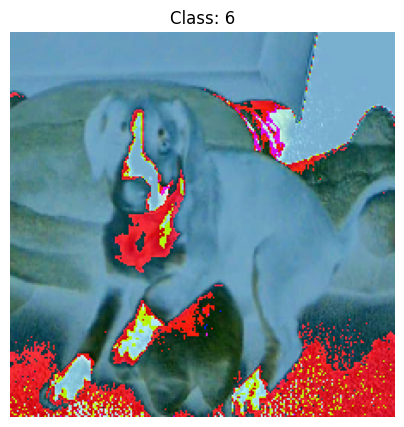

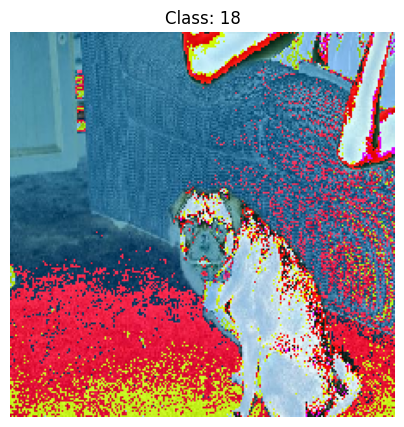

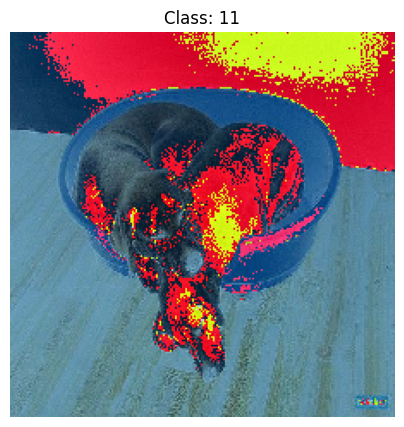

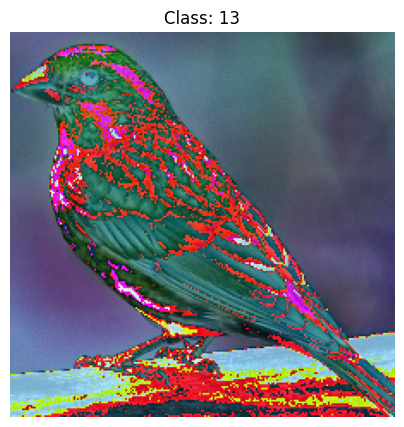

In [ ]:
images, labels = next(validationGenerator) # Retreive images from validation set

# Display 4 test images
for i in range(4):
    plt.figure(figsize=(5, 5))  # Create new figure
    plt.imshow(np.uint8(images[i] * 255))  # Rescale image from preprocessing
    plt.title(f'Class: {np.argmax(labels[i])}')  # Set class as the title
    plt.axis('off') # Hide axes
    plt.show() # Show the plot

validationGenerator.reset() # Start from first batch again

### 3. Develop the Baseline AI


Initialise the model

In [ ]:
# Load ResNet50 pretrained ImageNet including the top layer
resBase = ResNet50(weights='imagenet', input_shape=(imHeight, imWidth, 3))
model = models.Sequential()
model.add(resBase)
model.add(layers.Dense(20, activation='softmax')) # Add a dense layer for each class

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.002), loss='categorical_crossentropy', metrics=['accuracy']) # Compile the model with categorical crossentropy as the loss function and adam as the optimiser

102967424/102967424 [==============================] - 1s 0us/step


View the model architecture

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 1000)              25636712  
                                                                 
 dense (Dense)               (None, 20)                20020     
                                                                 
Total params: 25656732 (97.87 MB)
Trainable params: 25603612 (97.67 MB)
Non-trainable params: 53120 (207.50 KB)
_________________________________________________________________


Train the model

In [ ]:
# Train the model
history = model.fit_generator(
      trainGenerator,
      steps_per_epoch=80, # 2000 images = batch_size * steps
      epochs=300,
      validation_data=validationGenerator,
      validation_steps=10,  # 321 images = batch_size * steps
      verbose=2)

# Save the history data to a binary file
with open('trainingHistoryOG.pkl', 'wb') as f:
    pickle.dump(history.history, f)

<ipython-input-9-3476dbe41cb1>:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


Epoch 1/300
80/80 - 1162s - loss: 2.9899 - accuracy: 0.0692 - val_loss: 2.9931 - val_accuracy: 0.0625 - 1162s/epoch - 15s/step
Epoch 2/300
80/80 - 55s - loss: 2.9905 - accuracy: 0.0617 - val_loss: 2.9939 - val_accuracy: 0.0562 - 55s/epoch - 682ms/step
Epoch 3/300
80/80 - 54s - loss: 2.9814 - accuracy: 0.0641 - val_loss: 2.9898 - val_accuracy: 0.0625 - 54s/epoch - 673ms/step
Epoch 4/300
80/80 - 56s - loss: 2.9573 - accuracy: 0.0672 - val_loss: 3.0028 - val_accuracy: 0.0625 - 56s/epoch - 695ms/step
Epoch 5/300
80/80 - 53s - loss: 2.9520 - accuracy: 0.0814 - val_loss: 3.0111 - val_accuracy: 0.0625 - 53s/epoch - 665ms/step
Epoch 6/300
80/80 - 52s - loss: 2.9549 - accuracy: 0.0688 - val_loss: 3.0056 - val_accuracy: 0.0531 - 52s/epoch - 652ms/step
Epoch 7/300
80/80 - 55s - loss: 2.9496 - accuracy: 0.0759 - val_loss: 2.9480 - val_accuracy: 0.0750 - 55s/epoch - 687ms/step
Epoch 8/300
80/80 - 54s - loss: 2.9098 - accuracy: 0.0802 - val_loss: 2.8935 - val_accuracy: 0.0938 - 54s/epoch - 674ms/ste

Save the model

In [ ]:
model.save('/content/gdrive/MyDrive/42028/Assignment2/dataset_42028assg2_24505063/Image_Classification/40EpochsResNet50.h5') # Save model to desired path

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


### 4. Evaluate the Baseline AI

Load the model and its history

In [4]:
with open('trainingHistoryOG.pkl', 'rb') as f:
    history = pickle.load(f)

model = tf.keras.models.load_model('/content/gdrive/MyDrive/42028/Assignment2/dataset_42028assg2_24505063/Image_Classification/40EpochsResNet50.h5') # Change path to where model was saved

Visualise the model performance

Final Training Accuracy: 87.93%
Final Validation Accuracy: 65.31%


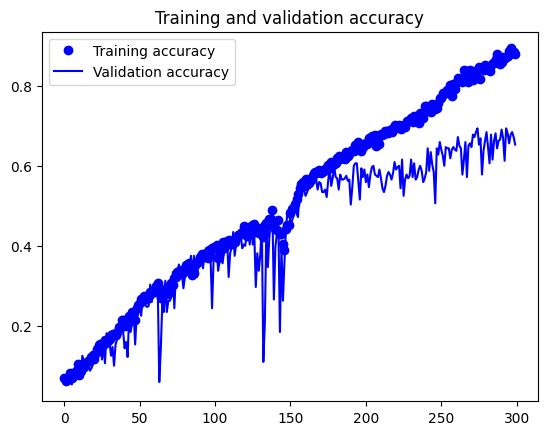

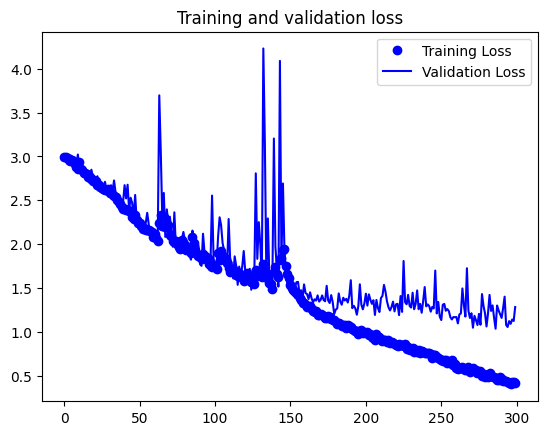

In [5]:
# Save parameters from the history dict
accuracy = history['accuracy']
valAccuracy = history['val_accuracy']
loss = history['loss']
valLoss = history['val_loss']
epochs = range(len(accuracy))

# Print final training and validation accuracy
print(f"Final Training Accuracy: {accuracy[-1]*100:.2f}%")
print(f"Final Validation Accuracy: {valAccuracy[-1]*100:.2f}%")

# Plot accuracy history
plt.figure()
plt.plot(epochs, accuracy, 'bo', label='Training accuracy')
plt.plot(epochs, valAccuracy, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

# Plot loss history
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training Loss')
plt.plot(epochs, valLoss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show() # Display charts

Display Confusion Matrix

<ipython-input-32-150d3394eb7d>:4: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  predictions = model.predict_generator(testGenerator, steps=len(testGenerator), verbose=1)


11/11 [==============================] - 5s 406ms/step


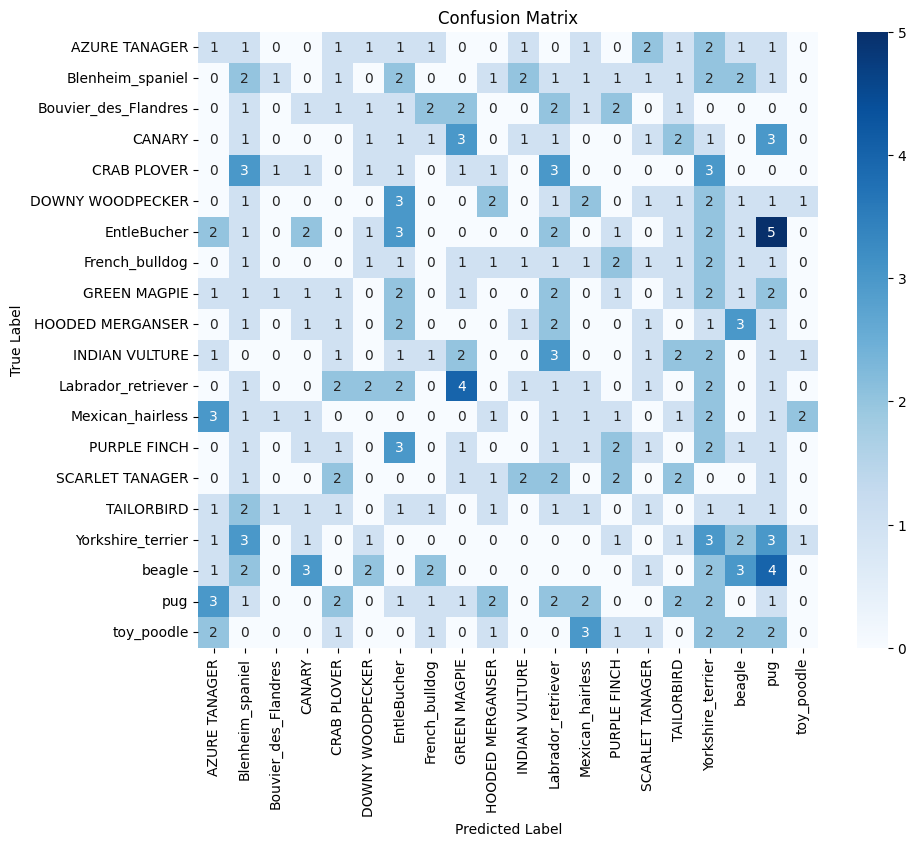

Test Accuracy: 0.05421686746987952


In [ ]:
testGenerator.reset() # Reset genernator to ensure full set is used

# Setup variables used in confusion matrix
predictions = model.predict_generator(testGenerator, steps=len(testGenerator), verbose=1)
predictions = np.argmax(predictions, axis=1) # Take the most confident prediction
classNames = testGenerator.classes
classIndices = list(testGenerator.class_indices.keys()) # Used to map model output to class names

# Generate the confusion matrix
cm = confusion_matrix(classNames, predictions)

# Plot the confusoin matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues', xticklabels=classIndices, yticklabels=classIndices)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# Calculate and print the accuracy
accuracy = accuracy_score(classNames, predictions)
print("Test Accuracy:", accuracy)

Get predictions in a single list from all images in test generator

In [ ]:
testGenerator.reset()  # Reset generator so that all images are used

# Store all images and labels in test generator
testImages, testLabels = next(testGenerator)
for i in range(len(testGenerator) - 1):  # For num batches
    genImages, genLabels = next(testGenerator)  # Get next batch
    testImages = np.concatenate((testImages, genImages)) # Append to images
    testLabels = np.concatenate((testLabels, genLabels)) # Append to labels

# Predict all test images
predictions = np.argmax(model.predict(testImages, verbose=1), axis=1)  # Select most confident predicted class
trueClasses = np.argmax(testLabels, axis=1) # Get true classes

11/11 [==============================] - 2s 95ms/step


Define function to plot images with labels

In [ ]:
def plotImages(images, actual_labels, predicted_labels, title):
    num_images = len(images)  # Get number of images available for plotting
    plt.figure(figsize=(15, 10))  # Define figure size
    for i in range(num_images):  # For each image
        plt.subplot(2, 4, i + 1)  # Add image to plot
        # Undo ResNet preprocessing
        image = images[i].astype('float32')
        image += np.abs(np.min(image))
        image /= np.max(image)
        # Display image and labels
        plt.imshow(image)
        plt.title(f"True: {actual_labels[i]}\nPred: {predicted_labels[i]}")
        plt.axis('off')
    plt.suptitle(title)  # Add subtitle
    plt.show()

Display up to 4 correctly and incorrectly classified images

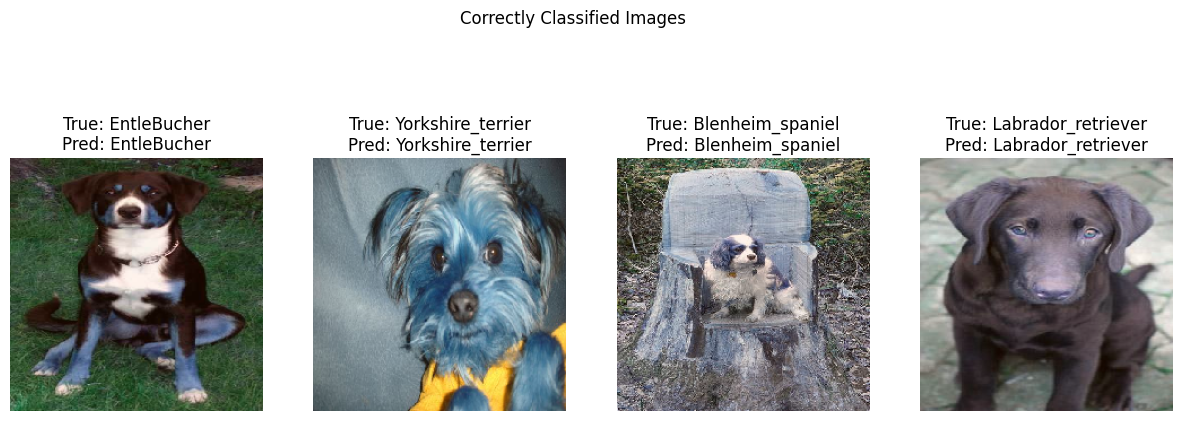

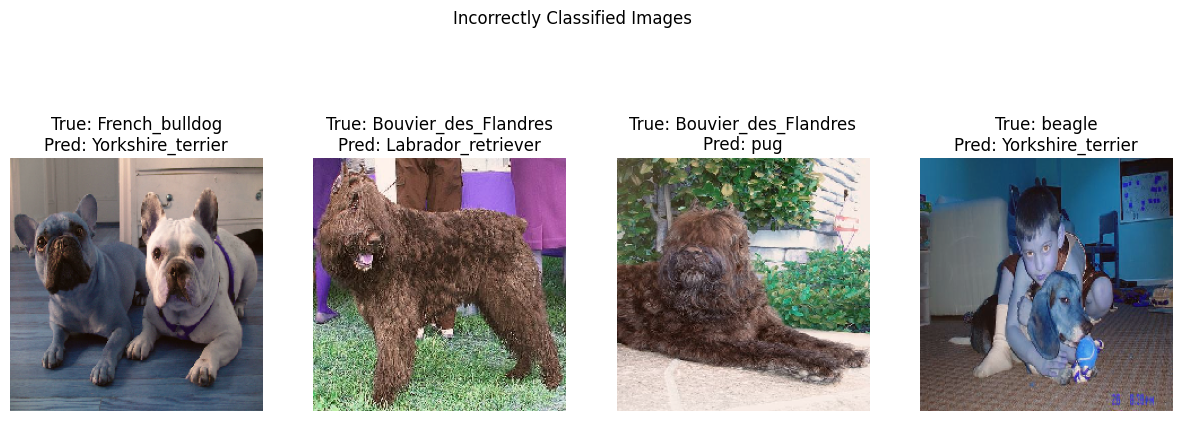

In [ ]:
# Find indices of correctly and incorrectly classified images
correctIndexList = np.where(predictions == trueClasses)[0]
incorrectIndexList = np.where(predictions != trueClasses)[0]

# Select up to 4 correctly identified and 4 incorrectly identified images and their respective labels
correctImages = testImages[correctIndexList[:min(4, len(correctIndexList))]]
incorrectImages = testImages[incorrectIndexList[:min(4, len(incorrectIndexList))]]
correctLabels = [list(testGenerator.class_indices.keys())[i] for i in trueClasses[correctIndexList[:min(4, len(correctIndexList))]]]
incorrectLabels = [list(testGenerator.class_indices.keys())[i] for i in trueClasses[incorrectIndexList[:min(4, len(incorrectIndexList))]]]
predictedCorrectLabels = [list(testGenerator.class_indices.keys())[i] for i in predictions[correctIndexList[:min(4, len(correctIndexList))]]]
incorrectPredictedLabels = [list(testGenerator.class_indices.keys())[i] for i in predictions[incorrectIndexList[:min(4, len(incorrectIndexList))]]]

# Display images
plotImages(correctImages, correctLabels, predictedCorrectLabels, "Correctly Classified Images")
plotImages(incorrectImages, incorrectLabels, incorrectPredictedLabels, "Incorrectly Classified Images")

### 5. Develop the Modified Model

In [ ]:
# Load resNet50 pretrained Imagenet not including top layer
resBase = ResNet50(weights='imagenet', include_top=False, input_shape=(imHeight, imWidth, 3))

# Set all layers except fully connected layer to be untrainable so that pretrained weights are not affected
#for layer in resBase.layers[:-2]:
 #   layer.trainable = False

# Recreate the model to enable modification while retaining layer passthroughs
input = layers.Input(shape=(imHeight, imWidth, 3))
x = resBase(input)

# Add new convolution steps before average pooling layer
x = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D((2, 2))(x)

x = layers.GlobalAveragePooling2D()(x) # Add global average pooling

# Add new dense layers with dropout
x = layers.Dense(1000, activation='relu', kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4))(x)
x = layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4))(x)
x = layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4))(x)
x = layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4))(x)
x = layers.Dropout(0.5)(x)
output = layers.Dense(20, activation='softmax')(x) # Add the final classification layer

# Create the model
model = Model(inputs=input, outputs=output)

# Compile the model with categorical crossentropy as the loss function and adam as the optimiser
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.002), loss='categorical_crossentropy', metrics=['accuracy'])

94765736/94765736 [==============================] - 5s 0us/step


View the model architecture

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 conv2d (Conv2D)             (None, 7, 7, 256)         4718848   
                                                                 
 batch_normalization (Batch  (None, 7, 7, 256)         1024      
 Normalization)                                                  
                                                                 
 conv2d_1 (Conv2D)           (None, 7, 7, 256)         590080    
                                                                 
 batch_normalization_1 (Bat  (None, 7, 7, 256)         1024      
 chNormalization)                                            

Reset genernator to ensure full set is used

In [ ]:
trainGenerator.reset()
validationGenerator.reset()

Train the model

In [ ]:
# Train the model
history = model.fit_generator(
      trainGenerator,
      steps_per_epoch=80, # 2000 images = batch_size * steps
      epochs=300,
      validation_data=validationGenerator,
      validation_steps=10,  # 320 images = batch_size * steps
      verbose=2)

# Save the history data to a binary file
with open('trainingHistoryMOD.pkl', 'wb') as f:
    pickle.dump(history.history, f)

<ipython-input-9-39932767c4fe>:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


Epoch 1/300
80/80 - 2257s - loss: 3.3958 - accuracy: 0.0892 - val_loss: 5572999.0000 - val_accuracy: 0.0625 - 2257s/epoch - 28s/step
Epoch 2/300
80/80 - 57s - loss: 3.2015 - accuracy: 0.0959 - val_loss: 10723.9121 - val_accuracy: 0.0594 - 57s/epoch - 716ms/step
Epoch 3/300
80/80 - 54s - loss: 3.0437 - accuracy: 0.1274 - val_loss: 3.0743 - val_accuracy: 0.1125 - 54s/epoch - 680ms/step
Epoch 4/300
80/80 - 55s - loss: 2.9458 - accuracy: 0.1364 - val_loss: 10.1853 - val_accuracy: 0.0875 - 55s/epoch - 682ms/step
Epoch 5/300
80/80 - 57s - loss: 2.8746 - accuracy: 0.1443 - val_loss: 7.6741 - val_accuracy: 0.1156 - 57s/epoch - 710ms/step
Epoch 6/300
80/80 - 54s - loss: 2.7696 - accuracy: 0.1741 - val_loss: 20.1683 - val_accuracy: 0.0812 - 54s/epoch - 675ms/step
Epoch 7/300
80/80 - 54s - loss: 2.6756 - accuracy: 0.1906 - val_loss: 17.2440 - val_accuracy: 0.0750 - 54s/epoch - 679ms/step
Epoch 8/300
80/80 - 56s - loss: 2.6369 - accuracy: 0.1946 - val_loss: 4.2138 - val_accuracy: 0.1344 - 56s/epoc

In [ ]:
model.save('/content/gdrive/MyDrive/42028/Assignment2/dataset_42028assg2_24505063/Image_Classification/40EpochsModifiedResNet50.h5') # Save the model to desired path

### 6. Evaluate the Modified AI

Load the trained model

In [5]:
with open('trainingHistoryMOD.pkl', 'rb') as f:
    history = pickle.load(f)

model = tf.keras.models.load_model('/content/gdrive/MyDrive/42028/Assignment2/dataset_42028assg2_24505063/Image_Classification/40EpochsModifiedResNet50.h5') # Change path to where model was saved

Visualise the model performance

Final Training Accuracy: 95.40%
Final Validation Accuracy: 77.19%


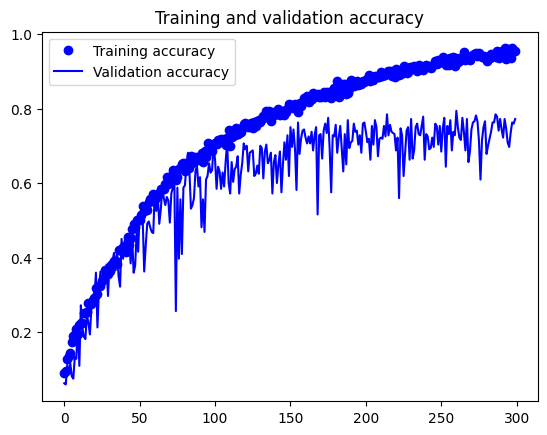

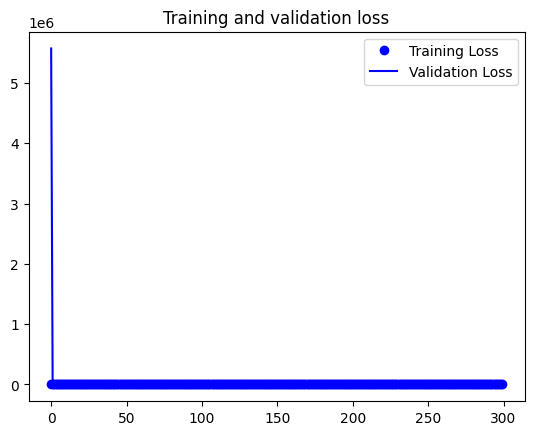

In [6]:
# Save parameters from the history dict
accuracy = history['accuracy']
valAccuracy = history['val_accuracy']
loss = history['loss']
valLoss = history['val_loss']
epochs = range(len(accuracy))

# Print final training and validation accuracy
print(f"Final Training Accuracy: {accuracy[-1]*100:.2f}%")
print(f"Final Validation Accuracy: {valAccuracy[-1]*100:.2f}%")

# Plot accuracy history
plt.figure()
plt.plot(epochs, accuracy, 'bo', label='Training accuracy')
plt.plot(epochs, valAccuracy, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

# Plot loss history
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training Loss')
plt.plot(epochs, valLoss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show() # Display charts

Display Confusion Matrix

<ipython-input-9-150d3394eb7d>:4: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  predictions = model.predict_generator(testGenerator, steps=len(testGenerator), verbose=1)


11/11 [==============================] - 125s 12s/step


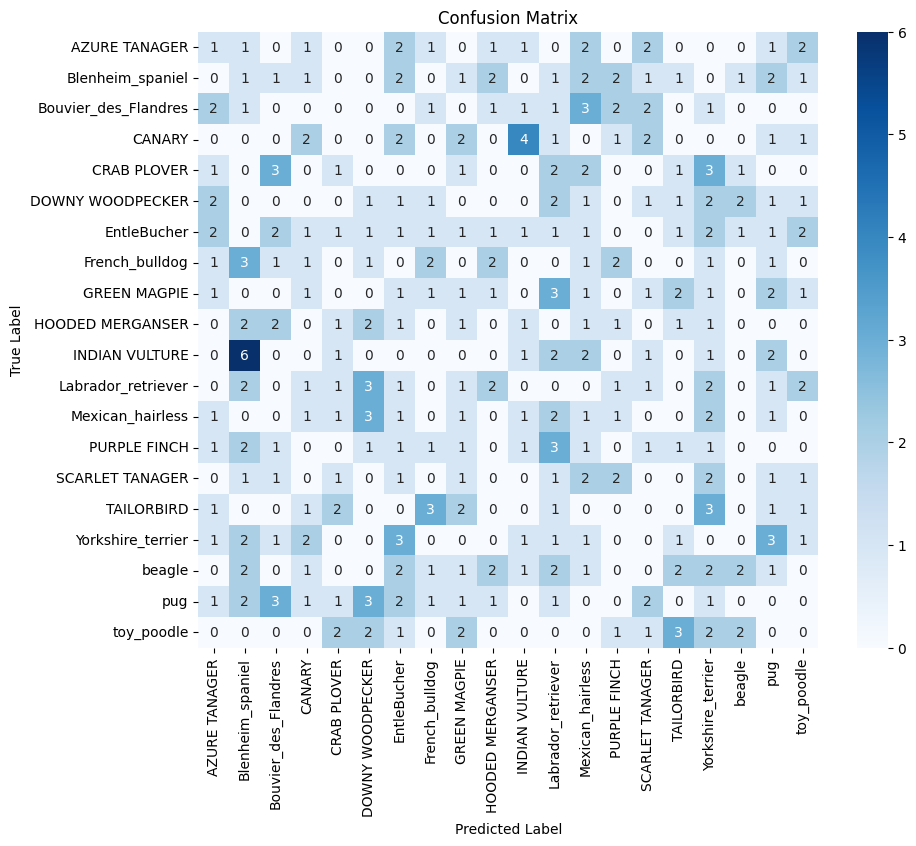

In [ ]:
testGenerator.reset() # Reset genernator to ensure full set is used

# Setup variables used in confusion matrix
predictions = model.predict_generator(testGenerator, steps=len(testGenerator), verbose=1)
predictions = np.argmax(predictions, axis=1) # Take the most confident prediction
classNames = testGenerator.classes
classIndices = list(testGenerator.class_indices.keys()) # Used to map model output to class names

# Generate the confusion matrix
cm = confusion_matrix(classNames, predictions)

# Plot the confusoin matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues', xticklabels=classIndices, yticklabels=classIndices)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# Calculate and print the accuracy
accuracy = accuracy_score(classNames, predictions)
print("Test Accuracy:", accuracy)

Get predictions in a single list from all images in test generator

In [ ]:
testGenerator.reset()  # Reset generator so that all images are used

# Store all images and labels in test generator
testImages, testLabels = next(testGenerator)
for i in range(len(testGenerator) - 1):  # For num batches
    genImages, genLabels = next(testGenerator)  # Get next batch
    testImages = np.concatenate((testImages, genImages)) # Append to images
    testLabels = np.concatenate((testLabels, genLabels)) # Append to labels

# Predict all test images
predictions = np.argmax(model.predict(testImages, verbose=1), axis=1)  # Select most confident predicted class
trueClasses = np.argmax(testLabels, axis=1) # Get true classes

Test Accuracy: 0.04216867469879518
11/11 [==============================] - 2s 101ms/step


Display up to 4 correctly and incorrectly classified images

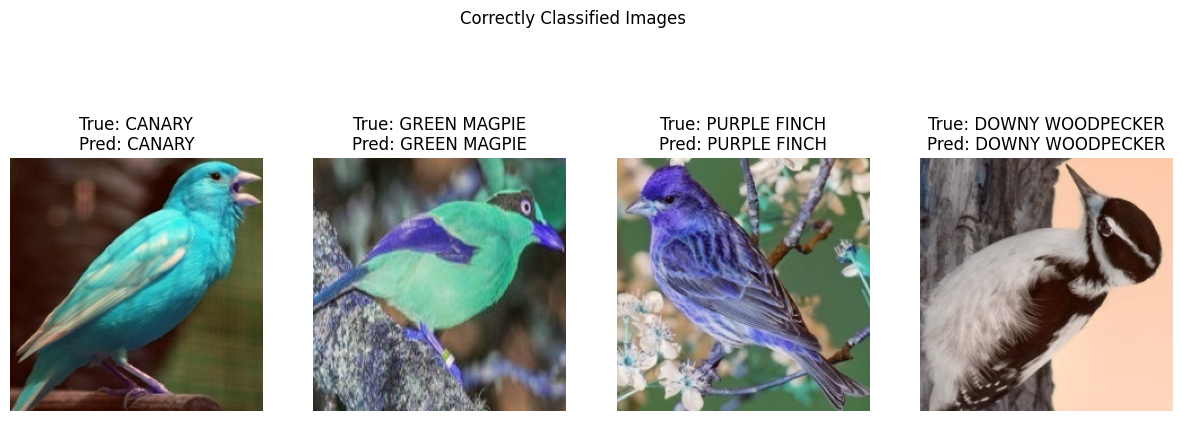

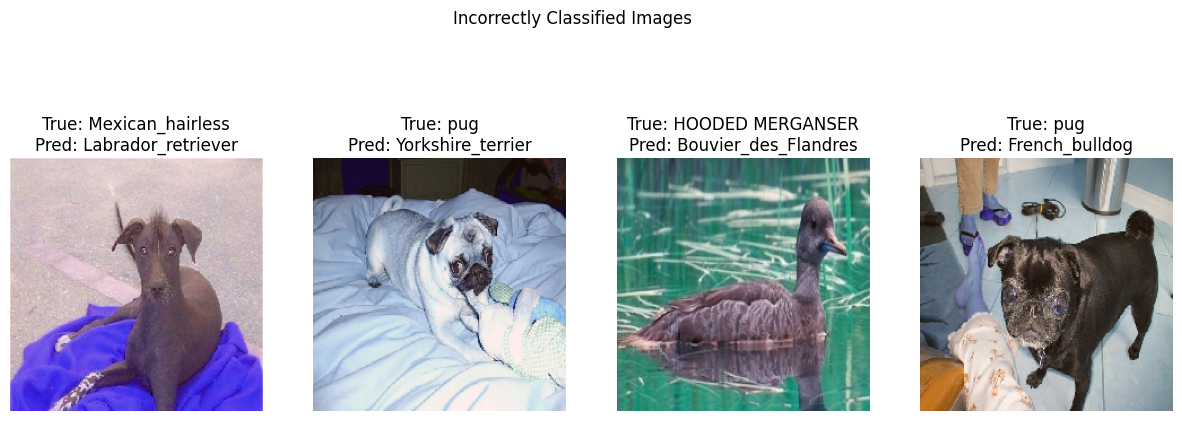

In [ ]:
# Find indices of correctly and incorrectly classified images
correctIndexList = np.where(predictions == trueClasses)[0]
incorrectIndexList = np.where(predictions != trueClasses)[0]

# Select up to 4 correctly identified and 4 incorrectly identified images and their respective labels
correctImages = testImages[correctIndexList[:min(4, len(correctIndexList))]]
incorrectImages = testImages[incorrectIndexList[:min(4, len(incorrectIndexList))]]
correctLabels = [list(testGenerator.class_indices.keys())[i] for i in trueClasses[correctIndexList[:min(4, len(correctIndexList))]]]
incorrectLabels = [list(testGenerator.class_indices.keys())[i] for i in trueClasses[incorrectIndexList[:min(4, len(incorrectIndexList))]]]
predictedCorrectLabels = [list(testGenerator.class_indices.keys())[i] for i in predictions[correctIndexList[:min(4, len(correctIndexList))]]]
incorrectPredictedLabels = [list(testGenerator.class_indices.keys())[i] for i in predictions[incorrectIndexList[:min(4, len(incorrectIndexList))]]]

# Display images
plotImages(correctImages, correctLabels, predictedCorrectLabels, "Correctly Classified Images")
plotImages(incorrectImages, incorrectLabels, incorrectPredictedLabels, "Incorrectly Classified Images")